## **Notebook PC#07**
## Self-Organizing Map (SOM) for the Travelling Salesperson Problem (TSP)<BR>
Code based on [this content](https://github.com/diego-vicente/som-tsp). <BR>

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Taylon Luan Congio Martins RA: 177379<br>
**Aluno(a):** Tiago C A Amorim RA: 100675

In [ ]:
# plot.py
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_network(cities, neurons, name='diagram.png', ax=None):
    """Plot a graphical representation of the problem"""
    mpl.rcParams['agg.path.chunksize'] = 10000

    if not ax:
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(cities['x'], cities['y'], color='red', s=4)
        axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)

        plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=200)
        plt.close()

    else:
        ax.scatter(cities['x'], cities['y'], color='red', s=4)
        # ax.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)
        ax.plot(neurons[:,0], neurons[:,1], '.', ls='-', color='#0063ba', markersize=2)
        return ax

def plot_route(cities, route, name='diagram.png', ax=None):
    """Plot a graphical representation of the route obtained"""
    mpl.rcParams['agg.path.chunksize'] = 10000

    if not ax:
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(cities['x'], cities['y'], color='red', s=4)
        route = cities.reindex(route)
        route.loc[route.shape[0]] = route.iloc[0]
        axis.plot(route['x'], route['y'], color='purple', linewidth=1)

        plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=200)
        plt.close()

    else:
        ax.scatter(cities['x'], cities['y'], color='red', s=4)
        route = cities.reindex(route)
        route.loc[route.shape[0]] = route.iloc[0]
        ax.plot(route['x'], route['y'], color='purple', linewidth=1)
        return ax

In [ ]:
# neuron.py
import numpy as np

def generate_network(size):
    """
    Generate a neuron network of a given size.

    Return a vector of two dimensional points in the interval [0,1].
    """
    return np.random.rand(size, 2)

def get_neighborhood(center, radix, domain):
    """Get the range gaussian of given radix around a center index."""

    # Impose an upper bound on the radix to prevent NaN and blocks
    if radix < 1:
        radix = 1

    # Compute the circular network distance to the center
    deltas = np.absolute(center - np.arange(domain))
    distances = np.minimum(deltas, domain - deltas)

    # Compute Gaussian distribution around the given center
    return np.exp(-(distances*distances) / (2*(radix*radix)))

def get_route(cities, network):
    """Return the route computed by a network."""
    cities['winner'] = cities[['x', 'y']].apply(
        lambda c: select_closest(network, c),
        axis=1, raw=True)

    return cities.sort_values('winner').index

In [ ]:
# io_helper.py
import pandas as pd

def read_tsp(filename):
    """
    Read a file in .tsp format into a pandas DataFrame

    The .tsp files can be found in the TSPLIB project. Currently, the library
    only considers the possibility of a 2D map.
    """
    with open(filename) as f:
        node_coord_start = None
        dimension = None
        lines = f.readlines()

        # Obtain the information about the .tsp
        i = 0
        while not dimension or not node_coord_start:
            line = lines[i]
            if line.startswith('DIMENSION :'):
                dimension = int(line.split()[-1])
            elif line.startswith('DIMENSION:'):
                dimension = int(line.split()[-1])
            if line.startswith('NODE_COORD_SECTION'):
                node_coord_start = i
            i = i+1

        print('Problem with {} cities read.'.format(dimension))

        f.seek(0)

        # Read a data frame out of the file descriptor
        cities = pd.read_csv(
            f,
            skiprows=node_coord_start + 1,
            sep=' ',
            names=['city', 'y', 'x'],
            dtype={'city': str, 'x': np.float64, 'y': np.float64},
            header=None,
            nrows=dimension,
            skipinitialspace=True
        )

        # cities.set_index('city', inplace=True)

        return cities

def normalize(points):
    """
    Return the normalized version of a given vector of points.

    For a given array of n-dimensions, normalize each dimension by removing the
    initial offset and normalizing the points in a proportional interval: [0,1]
    on y, maintining the original ratio on x.
    """
    ratio = (points.x.max() - points.x.min()) / (points.y.max() - points.y.min()), 1
    ratio = np.array(ratio) / max(ratio)
    norm = points.apply(lambda c: (c - c.min()) / (c.max() - c.min()))
    return norm.apply(lambda p: ratio * p, axis=1)

In [ ]:
# distance.py

def select_closest(candidates, origin):
    """Return the index of the closest candidate to a given point."""
    return euclidean_distance(candidates, origin).argmin()

def euclidean_distance(a, b):
    """Return the array of distances of two numpy arrays of points."""
    return np.linalg.norm(a - b, axis=1)

def route_distance(cities):
    """Return the cost of traversing a route of cities in a certain order."""
    points = cities[['x', 'y']]
    distances = euclidean_distance(points, np.roll(points, 1, axis=0))
    return np.sum(distances)

In [ ]:
# main.py

def main():

    problem = read_tsp('qa194.tsp')

    route = som(problem, 100000)

    problem = problem.reindex(route)

    distance = route_distance(problem)

    print('Route found of length {}'.format(distance))


def som(problem, iterations, learning_rate=0.8):
    """Solve the TSP using a Self-Organizing Map."""

    # Obtain the normalized set of cities (w/ coord in [0,1])
    cities = problem.copy()

    cities[['x', 'y']] = normalize(cities[['x', 'y']])

    # The population size is 8 times the number of cities
    n = cities.shape[0] * 8

    # Generate an adequate network of neurons:
    network = generate_network(n)
    print('Network of {} neurons created. Starting the iterations:'.format(n))

    for i in range(iterations):
        if not i % 100:
            print('\t> Iteration {}/{}'.format(i, iterations), end="\r")
        # Choose a random city
        city = cities.sample(1)[['x', 'y']].values
        winner_idx = select_closest(network, city)
        # Generate a filter that applies changes to the winner's gaussian
        gaussian = get_neighborhood(winner_idx, n//10, network.shape[0])
        # Update the network's weights (closer to the city)
        network += gaussian[:,np.newaxis] * learning_rate * (city - network)
        # Decay the variables
        learning_rate = learning_rate * 0.99997
        n = n * 0.9997

        # Check for plotting interval
        if not i % 2000:
          if i > 0:
            plot_network(cities, network, name='{:05d}.png'.format(i))

        # Check if any parameter has completely decayed.
        if n < 1:
            print('Radius has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
        if learning_rate < 0.001:
            print('Learning rate has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
    else:
        print('Completed {} iterations.'.format(iterations))

    plot_network(cities, network, name='final.png')

    route = get_route(cities, network)
    plot_route(cities, route, 'route.png')
    return route

if __name__ == '__main__':
    main()

Problem with 194 cities read.
Network of 1552 neurons created. Starting the iterations:


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Radius has completely decayed, finishing execution at 24487 iterations


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Route found of length 9911.601585677465


In [ ]:
problem = read_tsp('qa194.tsp')
with pd.option_context('display.max_rows', None,):
    print(problem)

Problem with 194 cities read.
    city           y           x
0      1  24748.3333  50840.0000
1      2  24758.8889  51211.9444
2      3  24827.2222  51394.7222
3      4  24904.4444  51175.0000
4      5  24996.1111  51548.8889
5      6  25010.0000  51039.4444
6      7  25030.8333  51275.2778
7      8  25067.7778  51077.5000
8      9  25100.0000  51516.6667
9     10  25103.3333  51521.6667
10    11  25121.9444  51218.3333
11    12  25150.8333  51537.7778
12    13  25158.3333  51163.6111
13    14  25162.2222  51220.8333
14    15  25167.7778  51606.9444
15    16  25168.8889  51086.3889
16    17  25173.8889  51269.4444
17    18  25210.8333  51394.1667
18    19  25211.3889  51619.1667
19    20  25214.1667  50807.2222
20    21  25214.4444  51378.8889
21    22  25223.3333  51451.6667
22    23  25224.1667  51174.4444
23    24  25233.3333  51333.3333
24    25  25234.1667  51203.0556
25    26  25235.5556  51330.0000
26    27  25235.5556  51495.5556
27    28  25242.7778  51428.8889
28    29  252

In [ ]:
# Code based on: https://stackoverflow.com/questions/41228209/making-gif-from-images-using-imageio-in-python
import os
import imageio

png_dir = '.'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('movie.gif', images)

<ipython-input-19-a7086ab0b9b2>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
<ipython-input-19-a7086ab0b9b2>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


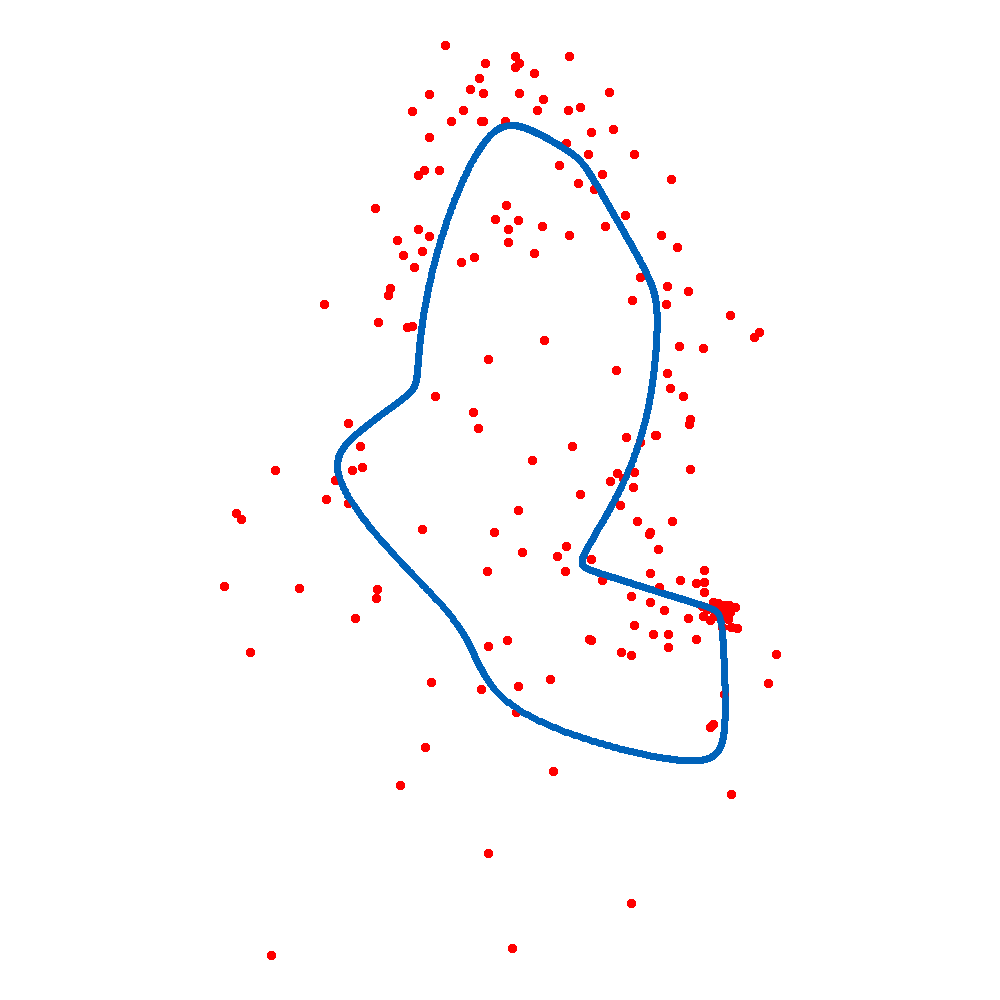

In [ ]:
from IPython.display import Image

Image('movie.gif', width=500, height=500)

Instruções para a atividade seguinte: Após concluir a execução das células anteriores, escolha alguma nova instância de TSP disponível
[aqui](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/), carregue o respectivo arquivo no ambiente Colab, apague os atuais arquivos [*.png] com o comando a seguir e execute as células na sequência, incluindo o nome do arquivo que você escolheu no local devido, o qual contém as coordenadas das cidades.

In [ ]:
!rm *.png

In [ ]:
# main2.py

def main():

    problem2 = read_tsp('a280.tsp') # Please, insert here the new filename.

    route2 = som(problem2, 100000)

    problem2 = problem2.reindex(route2)

    distance2 = route_distance(problem2)

    print('Route found of length {}'.format(distance2))


def som(problem, iterations, learning_rate=0.8):
    """Solve the TSP using a Self-Organizing Map."""

    # Obtain the normalized set of cities (w/ coord in [0,1])
    cities = problem.copy()

    cities[['x', 'y']] = normalize(cities[['x', 'y']])

    # The population size is 8 times the number of cities
    n = cities.shape[0] * 8

    # Generate an adequate network of neurons:
    network = generate_network(n)
    print('Network of {} neurons created. Starting the iterations:'.format(n))

    for i in range(iterations):
        if not i % 100:
            print('\t> Iteration {}/{}'.format(i, iterations), end="\r")
        # Choose a random city
        city = cities.sample(1)[['x', 'y']].values
        winner_idx = select_closest(network, city)
        # Generate a filter that applies changes to the winner's gaussian
        gaussian = get_neighborhood(winner_idx, n//10, network.shape[0])
        # Update the network's weights (closer to the city)
        network += gaussian[:,np.newaxis] * learning_rate * (city - network)
        # Decay the variables
        learning_rate = learning_rate * 0.99997
        n = n * 0.9997

        # Check for plotting interval
        if not i % 2000:
          if i > 0:
            plot_network(cities, network, name='{:05d}.png'.format(i))

        # Check if any parameter has completely decayed.
        if n < 1:
            print('Radius has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
        if learning_rate < 0.001:
            print('Learning rate has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
    else:
        print('Completed {} iterations.'.format(iterations))

    plot_network(cities, network, name='final.png')

    route = get_route(cities, network)
    plot_route(cities, route, 'route.png')
    return route

if __name__ == '__main__':
    main()

Problem with 280 cities read.
Network of 2240 neurons created. Starting the iterations:


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Radius has completely decayed, finishing execution at 25710 iterations


<ipython-input-13-f52cf0c40d9c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Route found of length 2838.8094194295445


In [ ]:
problem2 = read_tsp('a280.tsp') # Please, insert here the new filename.
with pd.option_context('display.max_rows', None,):
    print(problem2)

Problem with 280 cities read.
    city      y      x
0      1  288.0  149.0
1      2  288.0  129.0
2      3  270.0  133.0
3      4  256.0  141.0
4      5  256.0  157.0
5      6  246.0  157.0
6      7  236.0  169.0
7      8  228.0  169.0
8      9  228.0  161.0
9     10  220.0  169.0
10    11  212.0  169.0
11    12  204.0  169.0
12    13  196.0  169.0
13    14  188.0  169.0
14    15  196.0  161.0
15    16  188.0  145.0
16    17  172.0  145.0
17    18  164.0  145.0
18    19  156.0  145.0
19    20  148.0  145.0
20    21  140.0  145.0
21    22  148.0  169.0
22    23  164.0  169.0
23    24  172.0  169.0
24    25  156.0  169.0
25    26  140.0  169.0
26    27  132.0  169.0
27    28  124.0  169.0
28    29  116.0  161.0
29    30  104.0  153.0
30    31  104.0  161.0
31    32  104.0  169.0
32    33   90.0  165.0
33    34   80.0  157.0
34    35   64.0  157.0
35    36   64.0  165.0
36    37   56.0  169.0
37    38   56.0  161.0
38    39   56.0  153.0
39    40   56.0  145.0
40    41   56.0  137.0
41  

In [ ]:
# Code based on: https://stackoverflow.com/questions/41228209/making-gif-from-images-using-imageio-in-python
import os
import imageio

png_dir = '.'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('movie2.gif', images)

<ipython-input-24-52db64c8304d>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
<ipython-input-24-52db64c8304d>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


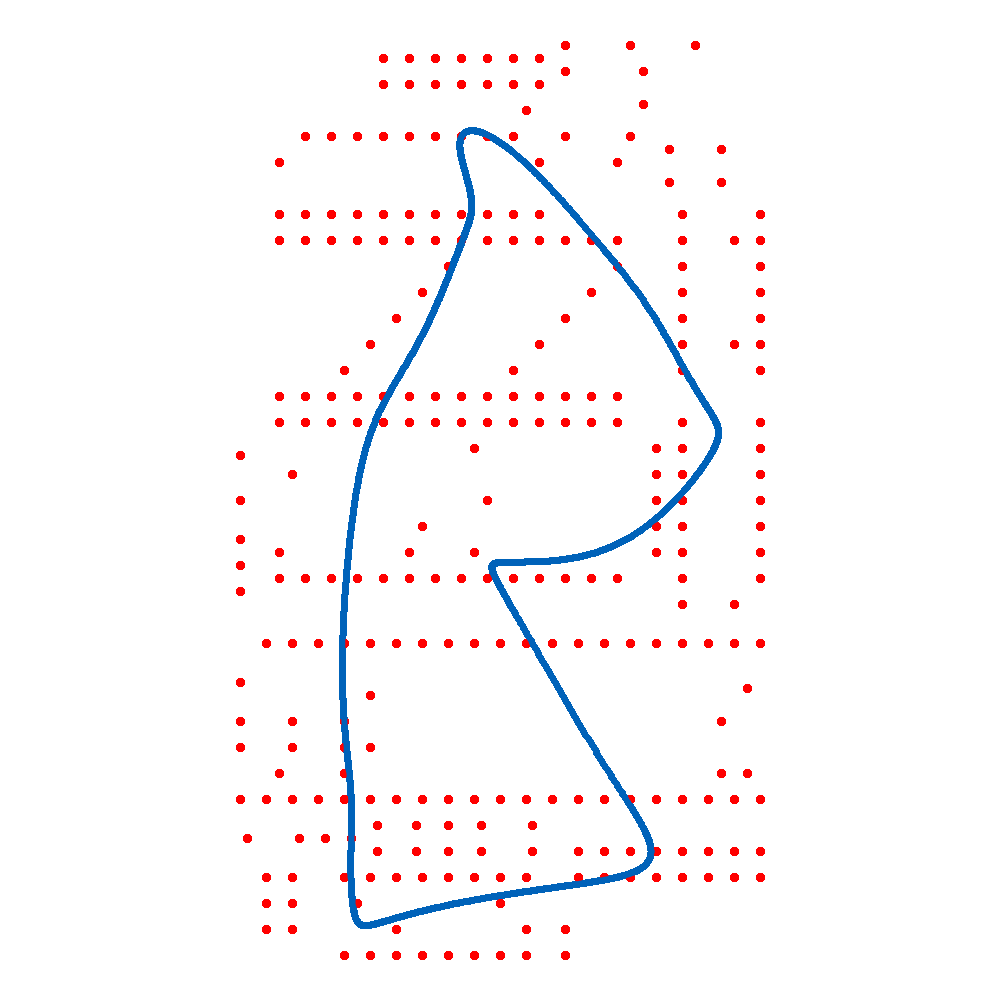

In [ ]:
Image('movie2.gif', width=500, height=500)

# 2. Projeto Computacional 07: Resolvendo o problema do caixeiro viajante com um mapa de Kohonen

Com a mesma ressalva feita no enunciado do PC06, execute o notebook [PC07_SOM_TSP.ipynb] para obter soluções de caixeiro viajante empregando um mapa de Kohonen. Para o primeiro caso de estudo, é necessário carregar o arquivo [qa194.tsp] fornecido pelo professor. Você é livre para escolher o segundo caso de estudo, dentre as opções em: http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/

Nesta atividade, as instâncias podem ser bem maiores que aquelas do PC06.

a. A solução adota um mapa auto-organizável unidimensional. Repare que a proposta difere daquela apresentada em aula. Na proposta apresentada em aula, há inserção e remoção de neurônios ao longo do processo de auto-organização, o que não ocorre aqui. Descreva o princípio de operação da técnica, que opera como “um anel elástico que vai se expandindo e aderindo às coordenadas das cidades”. Para tanto, consulte o material em: [https://diego.codes/post/som-tsp/].  

R:

Em ambas propostas é utilizado um mapa unidimensional fechado. Porém, na proposta apresentada em aula o algoritmo incluía e removia neurônios à medida que o objetivo era de ter exatamente um neurônio para cada cidade, e assim estar em acordo com o problema do caixeiro viajante. Nesta formulação o número de neurônios coincide com o número de cidades e não há inserção nem remoção de neurônios, os quais são dispostos espacialmente como um círculo em uma dimensão, na forma de um loop de tal modo que cada neurônio só está consciente do próximo neurônio e do anterior, desta forma, há uma mudança na topologia do mapa com a seguinte implicação: a função de neighborhood é modificada, agora, minimizar o perímetro do círculo significa encontrar o menor caminho para o viajante.

No código do PC07 é utilizado um número maior de neurônios que cidades (8 vezes maior). Em cada iteração é escolhida uma cidade e verificado o neurônio vencedor. É utilizado um esquema de decaimento da região de influência do neurônio vencedor para que no início seja mais explorado o domínio (maior número de vizinhos e maior movimento dos neurônios vizinhos do vencedor) e no final sejam feitas buscas pelo ótimo local. A trajetória ótima é indicada pela ordem dos neurônios vencedores para cada cidade.

b. Sabemos, então, que existem pelo menos três hardwares diferentes para resolver o problema do caixeiro viajante: (1) O computador digital padrão von Neumann; (2) Uma rede neural de Hopfield; e (3) Um mapa auto-organizável unidimensional em anel. Como a solução para o TSP é concebida em cada um desses hardwares?

R:

(1) Computador digital padrão Von Neumann: Pode-se resolver o problema do caixeiro viajante utilizando algoritmos de otimização combinatória, como o algoritmo de busca exaustiva, busca local ou mesmo genético. Uma grande dificuldade é que o número de possíveis trajetos cresce fatorialmente.

(2) Rede neural Hopfield: Formula-se o problema do caixeiro viajante como uma otimização em superfície de energia atrelada a uma dinâmica não-linear. A otimização da rede busca uma configuração mínima de energia que (idealmente) corresponde a uma rota que minimiza a distância percorrida pelo caixeiro. São utilizados termos de penalização na função de energia para que a resposta (estado de mínima energia) seja válida.

(3) Mapa auto-organizável em anel: O trajeto a ser seguido pelo caixeiro está associado a mapeamento unidimensional fechado. O conceito de vizinhança deste mapeamento fará com que os neurônios vizinhos caminhem para posições próximas entre si, assim minimizando o trajeto.  Em vez de declarar neurônios como um grid, se declara em forma de anel, onde cada neurônio da rede corresponde a uma cidade, o algoritmo ajusta os pesos entre neurônio de forma que cidades próximas geograficamente também se tornem próximas na topologia do mapa. A minimização da do perímetro do anel busca minimizar a distância percorrida pelo caixeiro.

c. Sabendo que a dificuldade para se resolver um problema depende da forma como o problema é formulado e do hardware a ser empregado na busca de sua solução, aponte as possíveis consequências práticas de se dispor de hardwares alternativos para resolver o TSP.

R:

Com hardwares alternativos o TSP pôde ser encarado de formas diferentes, mudando a formulação do problema. Foi possível obter soluções para o problema do caixeiro viajante de forma mais eficiente e de mais rápida convergência. Também foi possível trabalhar com um número maior de cidades com impacto quase linear no custo computacional, evitando problemas como a explosão de combinações possíveis.

